In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [14]:
test_size = 0.3
random_state = 42
np.random.seed(random_state)
cv_splits = 3

In [15]:
url = '../data/churn-analysis.csv'
df = pd.read_csv(url)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,True
1,502,0,42,8,159660.80,3,1,0,113931.57,True
2,699,0,39,1,0.00,2,0,0,93826.63,False
3,822,1,50,7,0.00,2,1,1,10062.80,False
4,501,1,44,4,142051.07,2,0,1,74940.50,False


In [16]:
target = 'Exited'
X = df.drop([target],axis=1)
y = df[target]

y.value_counts()

Exited
False    4204
True      810
Name: count, dtype: int64

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier


In [18]:
model_lbls = [
    'dt' # decision tree
    ,'nb' # gaussian native bayers
    ,'lp' # linear perceptron
    # 'svm'
    ,'knn' # K-nearest neighbours
    ,'adb' # adaboost
    ,'rf' # random forest
]

models = {
    'dt': {
        'name': 'Decision Tree       ',
        'estimator': DecisionTreeClassifier(random_state=random_state),
        'param': [{'max_depth':[*range(1,20)],'class_weight':[None,'balanced']}]
    },
    'nb': {
        'name': 'Gaussian Naive Bayes',
        'estimator': GaussianNB(),
        'param': [{'var_smoothing': [10**exp for exp in range(-3,-13,-1)]}]
    },
    'lp': {'name': 'Linear Perceptron   ',
       'estimator': Perceptron(random_state=random_state),
       'param': [{'early_stopping': [True,False], # use a small validation step to avoid overfit
                  'class_weight':[None,'balanced']}],
    },
  'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state), 
           'param': [{'kernel': ['rbf'], #gaussian radial basis function
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100], #C=1 prioritize the margin, C=100 prioritize the decrease of the training error
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],                     
             },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state),
           'param': [{'n_estimators':[10,20,30,40,50]
                     ,'learning_rate':[0.2,0.5,0.75,1,1.25,1.5] # is a hyperparameter that controls how much each individual "weak learner" (stump) contributes to the final combined model.
                     }]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(4,10)]
                     ,'n_estimators':[*range(10,60,10)]}]
          }
}

In [19]:
scorings = ['accuracy','precision_macro','recall_macro','f1_macro']

In [20]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=random_state, test_size=test_size)
print("Training on {} examples".format(len(X_train)))
print("Training on {} examples".format(len(X_test)))

Training on 3509 examples
Training on 1505 examples


In [21]:
clfs = []
results = pd.DataFrame(columns=['scoring','model','best_params','accuracy','precision_macro','recall_macro','f1_macro'])

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

for scoring in scorings:
    for m in model_lbls:
        clf = GridSearchCV(
            models[m]['estimator'],
            models[m]['param'],
            scoring=scoring,
            cv=cv_splits
        )
        clf.fit(X_train,y_train)
        clfs.append(clf)
        y_pred = clf.predict(X_test)
        cr = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
        results.loc[len(results)] = [
            scoring,
            models[m]['name'],
            clf.best_params_,
            cr['accuracy'],
            cr['macro avg']['precision'],
            cr['macro avg']['recall'],
            cr['macro avg']['f1-score']
        ]



c:\Users\richy\anaconda3\envs\MLDM2526\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\richy\anaconda3\envs\MLDM2526\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\richy\anaconda3\envs\MLDM2526\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

In [36]:
for score in scorings:
    scoring_filter = score
    display(results[results.scoring==scoring_filter]\
            .sort_values(by=scoring_filter, ascending=False)\
            .drop('scoring',axis=1)\
            .style.format(precision=3)\
            .set_caption('Results for scoring "{}"'.format(scoring_filter))
    )

,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
4,AdaBoost,"{'learning_rate': 1.25, 'n_estimators': 50}",0.879,0.829,0.702,0.741
5,Random forest,"{'max_depth': 7, 'n_estimators': 30}",0.879,0.877,0.670,0.716
0,Decision Tree,"{'class_weight': None, 'max_depth': 4}",0.872,0.800,0.700,0.734
1,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849,0.816,0.583,0.602
2,Linear Perceptron,"{'class_weight': None, 'early_stopping': True}",0.827,0.914,0.500,0.453
3,K Nearest Neighbor,{'n_neighbors': 6},0.821,0.525,0.502,0.465


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
11,Random forest,"{'max_depth': 4, 'n_estimators': 20}",0.871,0.896,0.636,0.677
10,AdaBoost,"{'learning_rate': 0.2, 'n_estimators': 50}",0.839,0.874,0.538,0.527
7,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849,0.816,0.583,0.602
6,Decision Tree,"{'class_weight': None, 'max_depth': 4}",0.872,0.800,0.700,0.734
8,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping': True}",0.175,0.587,0.501,0.150
9,K Nearest Neighbor,{'n_neighbors': 6},0.821,0.525,0.502,0.465


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
12,Decision Tree,"{'class_weight': 'balanced', 'max_depth': 4}",0.724,0.649,0.744,0.651
16,AdaBoost,"{'learning_rate': 1.5, 'n_estimators': 10}",0.862,0.767,0.699,0.724
17,Random forest,"{'max_depth': 9, 'n_estimators': 20}",0.880,0.854,0.687,0.731
13,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849,0.816,0.583,0.602
15,K Nearest Neighbor,{'n_neighbors': 1},0.728,0.524,0.524,0.524
14,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping': False}",0.260,0.504,0.503,0.259


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
22,AdaBoost,"{'learning_rate': 1.25, 'n_estimators': 50}",0.879,0.829,0.702,0.741
18,Decision Tree,"{'class_weight': None, 'max_depth': 4}",0.872,0.800,0.700,0.734
23,Random forest,"{'max_depth': 9, 'n_estimators': 20}",0.880,0.854,0.687,0.731
19,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849,0.816,0.583,0.602
21,K Nearest Neighbor,{'n_neighbors': 1},0.728,0.524,0.524,0.524
20,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping': False}",0.260,0.504,0.503,0.259


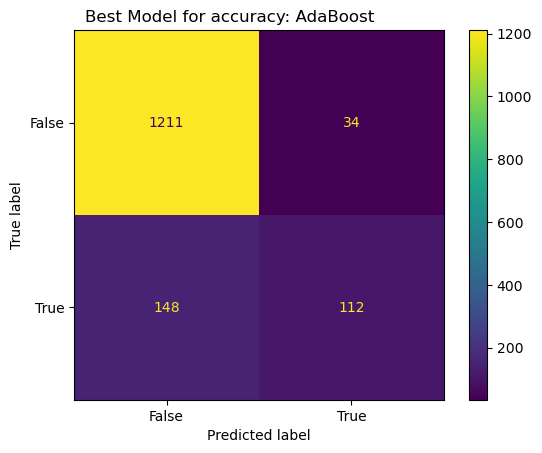

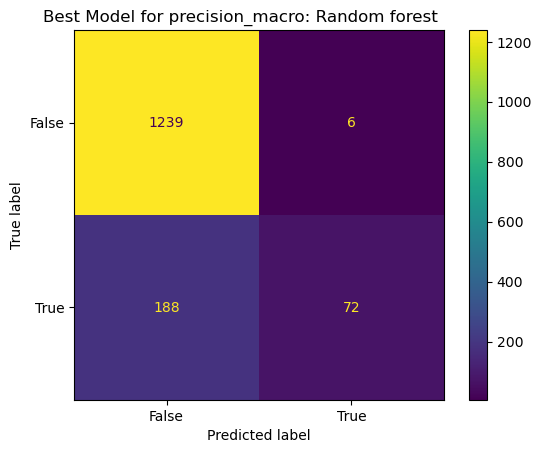

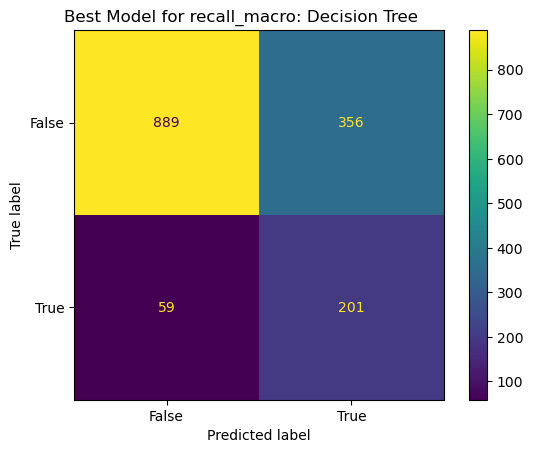

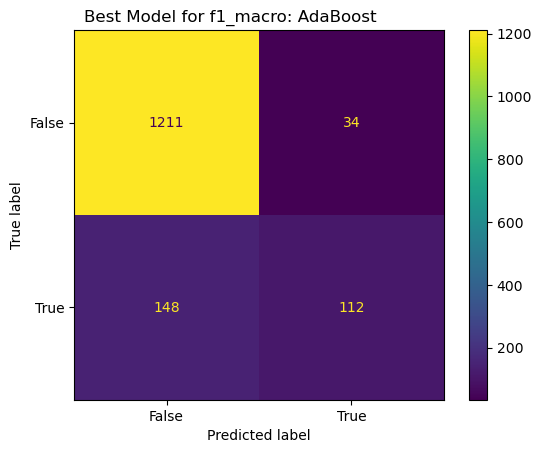

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

for score in scorings:
    scoring_filter = score
    best_row = results.loc[results.scoring==scoring_filter,scoring_filter].idxmax(axis=0)
    disp = ConfusionMatrixDisplay.from_estimator(X=X_test, y=y_test, estimator = clfs[best_row])
    disp.ax_.set_title("Best Model for {}: {}".format(score,results.at[best_row,'model']))